In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from astropy.table import Table
from tqdm import tqdm
import pickle, gzip
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, append=True)
filterwarnings("ignore", category=RuntimeWarning, append=True)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/home/paras/sharmapyenv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_DIR = "~/projects/PDSPL"

## Generate SLSim Galaxy Galaxy Lenses

### Define source and deflector populations

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# load red and blue galaxy catalogs
red_galaxy_catalog = Table.read(f"{PROJECT_DIR}/data/skypy_galaxy_catalogs/SKYPY_RED_GALAXIES_{1000.0}_SQDEG_0.fits",
                                  format="fits")
blue_galaxy_catalog = Table.read(f"{PROJECT_DIR}/data/skypy_galaxy_catalogs/SKYPY_BLUE_GALAXIES_{100.0}_SQDEG_0.fits",
                                   format="fits") 

# Initiate deflector population class.
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=red_galaxy_catalog,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area = Quantity(1000.0, "deg2"),
    gamma_pl = {"mean": 2.078, "std_dev": 0.16,}, # Auger et al. 2010
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=blue_galaxy_catalog,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=Quantity(100.0, "deg2"),
    catalog_type="skypy",
    extended_source_type="single_sersic",
)

In [4]:
print("# of red galaxies:", len(red_galaxy_catalog))
print("# of blue galaxies:", len(blue_galaxy_catalog))

# of red galaxies: 84567650
# of blue galaxies: 131301420


### Draw and Save Lenses for 20000 deg2 of sky area

In [ ]:
# define a sky area to render lenses for
sky_area = Quantity(value=200, unit="deg2")
scale_factor = 100 # scale factor to get 20000 deg2 worth of lenses
# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

# we draw from the same population multiple times!
for i in tqdm(range(scale_factor), desc="Drawing lenses"):
    selected_lenses = gg_lens_pop.draw_population(kwargs_lens_cuts={}) # we will apply lens cuts later, so we can save all the lenses and apply different cuts for different analyses
    with gzip.open(f"../data/SLSimLensesNoCuts/SLSIM_GGL_LENSES_{sky_area.value}_SQDEG_{i}.pkl.gz", "wb") as f:
        pickle.dump(selected_lenses, f)

Drawing lenses:   0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
print(f"Number of lenses in the sample: {len(selected_lenses)}")
print(f"Number of lenses per deg^2: {len(selected_lenses)/sky_area.value:.2f}")
print(f"Number of lenses for 20K deg^2: {len(selected_lenses)/sky_area.value*20000:.0f}")

Number of lenses in the sample: 44481
Number of lenses per deg^2: 222.41
Number of lenses for 20K deg^2: 4448100


In [70]:
num_images = []
for lens in selected_lenses:
    num_image = lens.image_number
    num_images.append(num_image)
num_images = np.array(num_images)
print(f"1 image fraction: {(num_images==1).sum()/len(num_images):.2f}")
print(f"2 image fraction: {(num_images==2).sum()/len(num_images):.2f}")
print(f"3 image fraction: {(num_images==3).sum()/len(num_images):.2f}")
print(f"4 image fraction: {(num_images==4).sum()/len(num_images):.2f}")

/Users/paras/Projects/repos/other/lenstronomy/lenstronomy/LensModel/Solver/epl_shear_solver.py:245: RuntimeWarning: invalid value encountered in multiply
  + stuff[1] * 1j


1 image fraction: 0.00
2 image fraction: 0.95
3 image fraction: 0.03
4 image fraction: 0.02


In [67]:
def satisfies_Collett_2015_cuts(lens, seeing = 0.45, band = 'i', mag_limit_band = 24.3, redshift_limit_source = None):
    """
    Checks whether a given lens satisfies the Collett 2015 (https://iopscience.iop.org/article/10.1088/0004-637X/811/1/20) cuts.

    Parameters:
    lens: a Lens object from slsim
    seeing: the seeing in arcseconds (default 0.45 for LSST Optimal Seeing)
    band: the band to use for magnitude cuts (default 'i')
    mag_limit_band: the magnitude limit for SNR > 20 in the given band (default 24.3 for LSST i-band, uses 5 sigma point source depth - 2.5 mag for extended sources)
    redshift_limit_source: optional redshift limit for the source (default None, meaning no cut)
    """

    # Criteria 1: Multiple imaging
    # The unlensed source position (xs​,ys​) must be within the Einstein radius θE​.
    xs, ys = lens.source(0).extended_source_position
    theta_E = lens.einstein_radius[0]
    condition_1 = np.sqrt(xs**2 + ys**2) < theta_E

    # Criteria 2: Image Resolution
    # The Einstein radius must be larger than the quadrature sum of the seeing and the source size.
    source_size = lens.source(0).angular_size # arcseconds
    condition_2 = theta_E > np.sqrt(source_size**2 + (seeing/2)**2) if seeing is not None else True

    # Criteria 3: Tangential Arc Resolution
    # The total magnification multiplied by the source size must exceed the seeing.
    total_magnification = lens.extended_source_magnification[0]
    condition_3 = total_magnification * source_size > seeing if seeing is not None else True

    # Criteria 4: Magnification
    # total magnification must be greater than 3
    condition_4 = total_magnification > 3

    # Criteria 5: SNR > 20
    if band is None or mag_limit_band is None:
        condition_5 = True
    else:
        if band == 'VIS':
            sum_mags = 0
            for b in ['r', 'i', 'z']:
                mag = lens.extended_source_magnitude(band=b, lensed=True)[0]
                sum_mags += mag
            mag_i_source_lensed = sum_mags / 3
        else:
            mag_i_source_lensed = lens.extended_source_magnitude(band=band, lensed=True)[0]
        condition_5 = mag_i_source_lensed < mag_limit_band

    # Criteria 6: Redshift cuts for Source if needed (e.g. for 4MOST)
    # z_s < 1.5
    condition_6 = lens.source(0).redshift < redshift_limit_source if redshift_limit_source is not None else True
    
    return condition_1 and condition_2 and condition_3 and condition_4 and condition_5 and condition_6

In [77]:
minimal_catalog = {
    'lens_id': [],
    'z_S': [],
    'z_D': [],
    'theta_E_arcsec': [],                # Einstein radius in arcseconds
    'source_radial_distance_arcsec': [], # sqrt(x_S^2 + y_S^2)
    'source_light_R_eff_arcsec': [],
    'es_total_magnification': [],        # mu_total
    'lensed_source_mag_i': [],           # For LSST
    'deflector_mag_i': [],
    'lensed_source_mag_r': [],           
    'deflector_mag_r': [],
    'lensed_source_mag_g': [],
    'deflector_mag_g': [],
}

for id, lens in enumerate(tqdm(selected_lenses, desc="Processing lenses for minimal catalog")):
    lens_id = id
    z_S = lens.source(0).redshift
    z_D = lens.deflector_redshift
    theta_E_arcsec = lens.einstein_radius[0]
    xs, ys = lens.source(0).extended_source_position
    source_radial_distance_arcsec = np.sqrt(xs**2 + ys**2)
    source_light_R_eff_arcsec = lens.source(0).angular_size
    es_total_magnification = lens.extended_source_magnification[0]
    lensed_source_mag_i = lens.extended_source_magnitude(band='i', lensed=True)[0]
    deflector_mag_i = lens.deflector_magnitude(band='i')
    lensed_source_mag_r = lens.extended_source_magnitude(band='r', lensed=True)[0]
    deflector_mag_r = lens.deflector_magnitude(band='r')
    lensed_source_mag_g = lens.extended_source_magnitude(band='g', lensed=True)[0]
    deflector_mag_g = lens.deflector_magnitude(band='g')

    minimal_catalog['lens_id'].append(lens_id)
    minimal_catalog['z_S'].append(z_S)
    minimal_catalog['z_D'].append(z_D)
    minimal_catalog['theta_E_arcsec'].append(theta_E_arcsec)
    minimal_catalog['source_radial_distance_arcsec'].append(source_radial_distance_arcsec)
    minimal_catalog['source_light_R_eff_arcsec'].append(source_light_R_eff_arcsec)
    minimal_catalog['es_total_magnification'].append(es_total_magnification)
    minimal_catalog['lensed_source_mag_i'].append(lensed_source_mag_i)
    minimal_catalog['deflector_mag_i'].append(deflector_mag_i)
    minimal_catalog['lensed_source_mag_r'].append(lensed_source_mag_r)
    minimal_catalog['deflector_mag_r'].append(deflector_mag_r)
    minimal_catalog['lensed_source_mag_g'].append(lensed_source_mag_g)
    minimal_catalog['deflector_mag_g'].append(deflector_mag_g)

minimal_catalog_table = Table(minimal_catalog)

Processing lenses for minimal catalog: 100%|██████████| 44481/44481 [05:34<00:00, 133.11it/s]


In [78]:
def satisfies_Collett_2015_cuts_table(lens_catalog_table, 
                                      seeing = 0.45, 
                                      mag_limit_i_band = 24.3, 
                                      redshift_limit_source = None):
    """
    Checks whether lenses in a given lens catalog table satisfy the Collett 2015 (https://iopscience.iop.org/article/10.1088/0004-637X/811/1/20) cuts.

    Parameters:
    lens_catalog_table: an Astropy Table containing lens properties
    seeing: the seeing in arcseconds (default 0.45 for LSST Optimal Seeing)
    mag_limit_i_band: the magnitude limit for SNR > 20 in the i band (default 24.3 for LSST i-band, uses 5 sigma point source depth - 2.5 mag for extended sources)
    redshift_limit_source: optional redshift limit for the source (default None, meaning no cut)

    Returns:
    A boolean array indicating which lenses satisfy the cuts.
    """
    conditions = np.ones(len(lens_catalog_table), dtype=bool)

    # Criteria 1: Multiple imaging
    condition_1 = lens_catalog_table['source_radial_distance_arcsec'] < lens_catalog_table['theta_E_arcsec']
    conditions &= condition_1

    # Criteria 2: Image Resolution
    condition_2 = lens_catalog_table['theta_E_arcsec'] > np.sqrt(lens_catalog_table['source_light_R_eff_arcsec']**2 + (seeing/2)**2)
    conditions &= condition_2

    # Criteria 3: Tangential Arc Resolution
    condition_3 = lens_catalog_table['es_total_magnification'] * lens_catalog_table['source_light_R_eff_arcsec'] > seeing
    conditions &= condition_3

    # Criteria 4: Magnification
    condition_4 = lens_catalog_table['es_total_magnification'] > 3
    conditions &= condition_4

    # Criteria 5: SNR > 20
    if mag_limit_i_band is not None:
        mag_i_source_lensed = lens_catalog_table['lensed_source_mag_i']
        condition_5 = mag_i_source_lensed < mag_limit_i_band
        conditions &= condition_5
    
    # Criteria 6: Redshift cuts for Source if needed (e.g. for 4MOST)
    if redshift_limit_source is not None:
        condition_6 = lens_catalog_table['z_S'] < redshift_limit_source
        conditions &= condition_6

    return lens_catalog_table[conditions]

Text(1, 0.3, 'LSST Yearly Cuts Calculation:\n\n5$\\sigma$ point source depth $-$ 4.0 mag for extended sources\nDepth decreases as $-2.5 \\log_{10}(\\sqrt{10/t})$\nSeeing fixed to 0.62" (optimal) or 0.8" (median)')

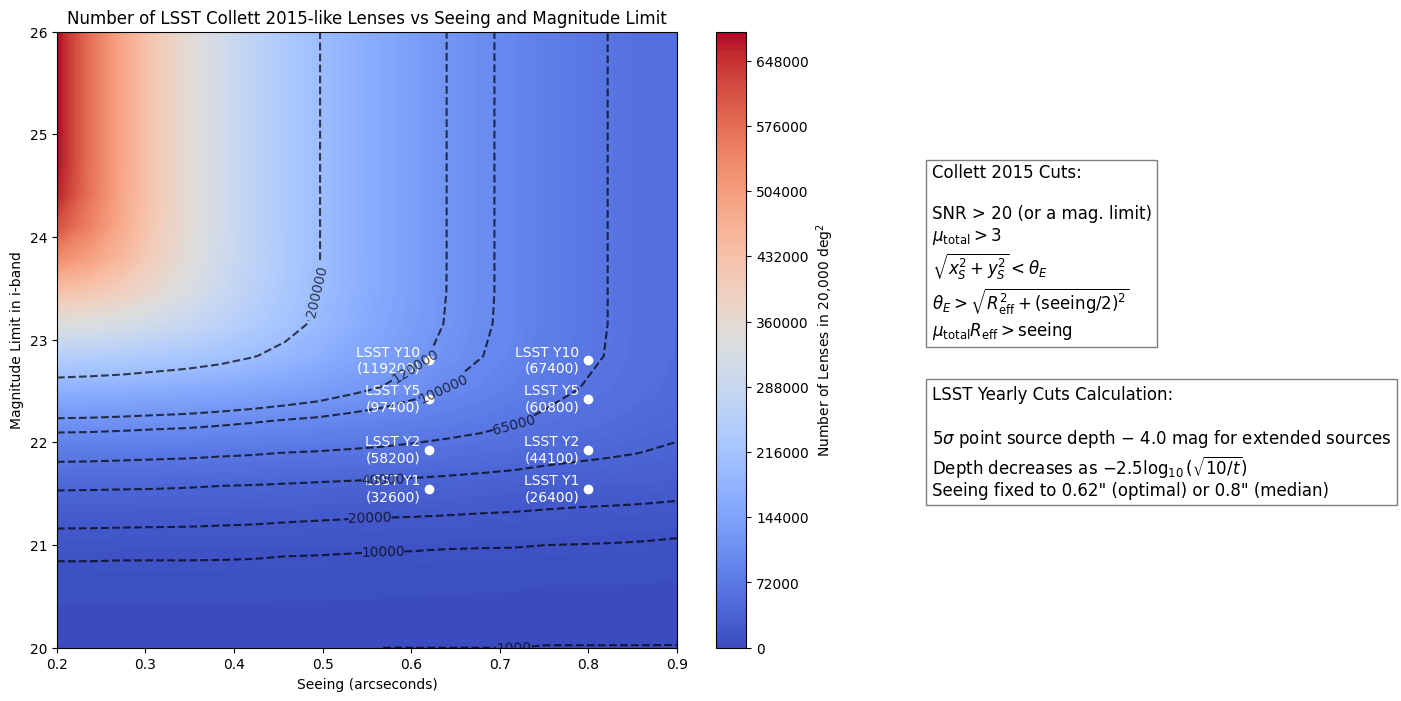

In [184]:
# find number of lenses over a grid of seeing values and magnitude limits using the minimal catalog table and the Collett 2015 cuts function defined above
seeing_grid, mag_limit_grid = np.meshgrid(np.linspace(0.2, 0.9, 20), np.linspace(20, 26, 20))
num_lenses_grid = np.zeros(seeing_grid.shape)

for i in range(seeing_grid.shape[0]):
    for j in range(seeing_grid.shape[1]):
        seeing = seeing_grid[i, j]
        mag_limit = mag_limit_grid[i, j]
        selected_lenses_table = satisfies_Collett_2015_cuts_table(
            minimal_catalog_table,
            seeing=seeing,
            mag_limit_i_band=mag_limit,
        )
        num_lenses_grid[i, j] = len(selected_lenses_table)*20000/sky_area.value

# plot the number of lenses as a function of seeing and magnitude limit
plt.figure(figsize=(10, 8))
cp = plt.contourf(seeing_grid, mag_limit_grid, num_lenses_grid, levels=200, cmap='coolwarm')
# make contours at values of 1000, 10000, 50000, 100000 and label them
contour_levels = [1000, 10000, 20000, 40000, 65000, 100000, 120000, 200000]
cp_contours = plt.contour(seeing_grid, mag_limit_grid, num_lenses_grid, levels=contour_levels, colors='black', linestyles='dashed', alpha=0.7)
plt.clabel(cp_contours, fmt='%d', inline=True, fontsize=10)
plt.colorbar(cp, label='Number of Lenses in 20,000 deg$^2$')
plt.xlabel('Seeing (arcseconds)')
plt.ylabel('Magnitude Limit in i-band')
plt.title('Number of LSST Collett 2015-like Lenses vs Seeing and Magnitude Limit')
# plt.grid()

# Also we will now mark the following interesting points on the plot:
# 5 sigma point source depth is known => 20 sigma point source depth is = 2.5*log10(4) ~ 1.5 mag brighter
# extended sources can be typically 2.5 mag shallower => => 4 mag shallower for SNR > 20
extended_source_shallowing_mag = 4.0
seeing_LSST_optimal = 0.62
seeing_LSST_median = 0.80
for seeing_LSST in [seeing_LSST_optimal, seeing_LSST_median]:
    lsst_y10_mag_cut = 26.8 - extended_source_shallowing_mag  # 5 sigma point source depth - 4 mag for extended sources
    lsst_years_to_consider = {
        'Y1': {'seeing': seeing_LSST, 'color': 'white', 'year_num': 1,}, 
        'Y2': {'seeing': seeing_LSST, 'color': 'white', 'year_num': 2,}, 
        'Y5': {'seeing': seeing_LSST, 'color': 'white', 'year_num': 5,}, 
        'Y10': {'seeing': seeing_LSST, 'color': 'white', 'year_num': 10,},
    }
    for year, cuts in lsst_years_to_consider.items():
        year_num = cuts['year_num']
        # deepth(Y10) - 2.5*log10(sqrt(10/t))
        mag_limit = lsst_y10_mag_cut - 2.5 * np.log10(np.sqrt(10/year_num))
        cuts['mag_limit'] = mag_limit

    for year, cuts in lsst_years_to_consider.items():
        seeing = cuts['seeing']
        mag_limit = cuts['mag_limit']
        color = cuts['color']
        plt.plot(seeing, mag_limit, marker='o', color=color, label=f'LSST {year}')
        sample_size = len(satisfies_Collett_2015_cuts_table(
            minimal_catalog_table,
            seeing=seeing,
            mag_limit_i_band=mag_limit,
        ))*20000/sky_area.value
        plt.text(seeing-0.01, mag_limit, f'LSST {year}\n({int(sample_size)})', ha='right', va='center', color=color)

### Add text next to the plot that shows cuts used in Collett 2015 in LATEX format
textstr = '\n'.join((
    r'Collett 2015 Cuts:'+'\n',
    # r'$0.5 < \theta_E < 4$ arcsec',
    r'SNR > 20 (or a mag. limit)',
    r'$\mu_{\rm total} > 3$',
    r'$\sqrt{x_S^2 + y_S^2} < \theta_E$',
    r'$\theta_E > \sqrt{R_{\rm eff}^2 + ({\rm seeing}/2)^2}$',
    r'$\mu_{\rm total} R_{\rm eff} > {\rm seeing}$',
))
plt.gcf().text(1, 0.5, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

### Add another box that explains how different years cuts were calculated
textstr2 = '\n'.join((
    r'LSST Yearly Cuts Calculation:'+'\n',
    f'5$\\sigma$ point source depth $-$ {extended_source_shallowing_mag} mag for extended sources',
    r'Depth decreases as $-2.5 \log_{10}(\sqrt{10/t})$',
    rf'Seeing fixed to {seeing_LSST_optimal}" (optimal) or {seeing_LSST_median}" (median)'
))
plt.gcf().text(1, 0.3, textstr2, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_87507/3626800184.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels((y_ticks*20000/sky_area.value).astype(int));


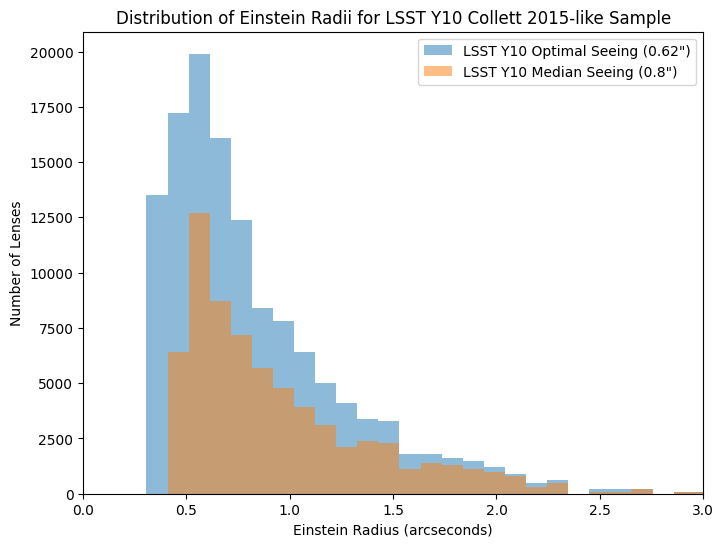

In [189]:
# Plot the einstein radius distribution for the lenses that satisfy the Collett 2015 cuts for LSST Y10 optimal seeing and median seeing
collett_lsst_y10_optimal_sample_table = satisfies_Collett_2015_cuts_table(
    minimal_catalog_table,
    seeing=seeing_LSST_optimal,
    mag_limit_i_band = 23.8,
)
collett_lsst_y10_median_sample_table = satisfies_Collett_2015_cuts_table(
    minimal_catalog_table,
    seeing=seeing_LSST_median,
    mag_limit_i_band=lsst_years_to_consider['Y10']['mag_limit'],
)
plt.figure(figsize=(8,6))
plt.hist(collett_lsst_y10_optimal_sample_table['theta_E_arcsec'], bins=np.linspace(0, 5, 50), alpha=0.5, label=f'LSST Y10 Optimal Seeing ({seeing_LSST_optimal}")')
plt.hist(collett_lsst_y10_median_sample_table['theta_E_arcsec'], bins=np.linspace(0, 5, 50), alpha=0.5, label=f'LSST Y10 Median Seeing ({seeing_LSST_median}")')
plt.xlabel("Einstein Radius (arcseconds)")
plt.ylabel("Number of Lenses")
plt.title("Distribution of Einstein Radii for LSST Y10 Collett 2015-like Sample")
plt.legend()
plt.xlim(0, 3)

# multiply y ticks by 20000/sky_area.value to get number of lenses in 20,000 deg^2
ax = plt.gca()
y_ticks = ax.get_yticks()
ax.set_yticklabels((y_ticks*20000/sky_area.value).astype(int));

In [ ]:
# make a table for properties of the GGL Sample

##### PROPERTIES TO INCLUDE IN THE TABLE #####
# -----------------------------------------------------------------------------------------------------------------------------
# --- System Properties ---
# 'lens_id',                            # Unique identifier
# 'z_S',                                # Source Redshift
# 'z_D',                                # Deflector (Lens) Redshift
# 'theta_E_arcsec',                     # Einstein Radius 
# 'num_images',                         # (Number of distinct arc components/images)

# --- Source Galaxy Light [SERSIC] ---
# 'source_id',
# 'x_source_position_arcsec',
# 'y_source_position_arcsec',
# 'unlensed_source_mag_<band>',         # (Intrinsic magnitude for g,r,i,z,y)
# 'lensed_source_mag_<band>',           # (Total integrated magnitude of the arcs: important for SNR)
# 'source_light_R_eff_arcsec',          # (Half-light radius)
# 'source_light_n_sersic',              # (Sersic index, usually 1 for disks, 4 for bulges)
# 'source_light_e1',                    # (Ellipticity component 1)
# 'source_light_e2',                    # (Ellipticity component 2)
# 'source_light_ellipticity',           # (sqrt(e1^2 + e2^2))
# 'source_light_position_angle_deg',    # (0.5 * arctan2(e2, e1))
# 'es_magnification',                   # (Total magnification of the extended source geometry)

# --- Deflector Light (Lens Galaxy) [SERSIC] ---
# 'deflector_mag_<band>',               # (Intrinsic lens magnitude for g,r,i,z,y)
# 'deflector_light_R_eff_arcsec',       # (Half-light radius of the lens galaxy)
# 'deflector_light_n_sersic',
# 'deflector_light_e1',
# 'deflector_light_e2',
# 'deflector_light_ellipticity',
# 'deflector_light_position_angle_deg', 
# 'deflector_light_axis_ratio',         # (q)
# 'x_deflector_light_position_arcsec',  # (Usually 0, unless modeling offset)
# 'y_deflector_light_position_arcsec',

# --- Deflector Mass (Lens Galaxy) [PEMD + SHEAR] ---
# 'deflector_stellar_mass',             # (log_10 M_sun)
# 'deflector_velocity_dispersion',      # (sigma_v_D in km/s)
# 'deflector_pl_slope',                 # (gamma_pl, Power Law slope, usually ~2.0)
# 'deflector_mass_e1',
# 'deflector_mass_e2',
# 'deflector_mass_ellipticity',
# 'deflector_mass_position_angle_deg',  # (Often tied to light PA, but good to keep separate)
# 'external_shear_gamma1',
# 'external_shear_gamma2',
# 'external_shear_amplitude',
# 'external_shear_position_angle_deg',

# --- Observability & Derived Metrics (Crucial for LSST Selection) ---
# 'contrast_ratio_<band>',              # (Flux_source / Flux_lens: Determines if arc is visible)
# 'snr_<band>',                         # (Estimated Signal-to-Noise of the arc)
# 'is_resolved',                        # (Boolean: theta_E > seeing)
# 'confusion_noise_sigma',              # (Optional: Noise due to lens light contamination)
# -----------------------------------------------------------------------------------------------------------------------------